# **Chapter 13 (PyTorch Recipes)**
## *Deep Learning for Time Series Forecasting*, 

This chapter covers more advanced deep learning architectures using TensorFlow/Keras and PyTorch. The chapter starts with a high-level API (Keras) and then dives into more complex implementations, using a lower-level API (PyTorch).

In this chapter, you will see the following recipes:
* Forecasting with an RNN using PyTorch
* Forecasting with LSTM using PyTorch
* Forecasting with a GRU using PyTorch

# Technical Requirements

It is recommended that you create two separate virtual Python environments – one for TensorFlow/Keras and one for PyTorch. You can install all the required dependencies and their specific versions without causing conflicts in other environments. If you prefer, you can still try and install them together in a new virtual environment. If you need a quick refresher on creating a virtual Python environment, check out the *Development environment setup* recipe from **Chapter 1**, *Getting Started with Time Series Analysis*. The chapter covers two methods – using `conda` and `venv`.

The following instructions will create two virtual environments using `conda`. You can call the environments any name you like.


### Installing PyTorch
The following example will name the environment pytorch. This will install CPU-only support:

```
conda create -n pytorch python=3.9 -y
conda activate pytorch
conda install pytorch torchvision torchaudio cpuonly -c pytorch
```

For GPU instructions, the latest information, or troubleshooting, please visit the documentation here: https://pytorch.org/.

To make the new pytorch environment visible within Jupyter, you can run the following code:

```
python -m ipykernel install --user --name pytorch --displayname "pytorch"
```

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

In [4]:
import matplotlib 
import pytorch_lightning as pl
import torch 

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
numpy -> {np.__version__}
PyTorch Lightning -> {pl.__version__}
Torch -> {torch.__version__}
''')


Matplotlib -> 3.5.1
pandas -> 1.4.2   
numpy -> 1.22.3
PyTorch Lightning -> 1.6.1
Torch -> 1.11.0



In [5]:
###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [12, 6]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

In [6]:
path = Path('../../datasets/Ch13/')
daily_temp = pd.read_csv(path.joinpath('daily_weather.csv'), 
                      index_col='DateTime', 
                      parse_dates=True)
daily_temp.columns = ['y']
energy = pd.read_csv(path.joinpath('energy_consumption.csv'), 
                     index_col='Month', 
                     parse_dates=True)
energy.columns = ['y']

air = pd.read_csv(path.joinpath('air_passenger.csv'), 
                  index_col='date', 
                  parse_dates=True)
air.columns = ['y']

In [7]:
daily_temp.index.freq = 'D'
energy.index.freq = 'MS'
air.index.freq = 'M'

In [8]:
print(daily_temp.index.freq)
print(energy.index.freq)
print(air.index.freq)

<Day>
<MonthBegin>
<MonthEnd>


## Tranform the data sets
### Windowing

In [9]:
def handle_missing_data(df):
    n = int(df.isna().sum())
    if n > 0:
        print(f'found {n} missing observations...')
        df.ffill(inplace=True)
        
        
def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()
    

def split_data(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test

In [10]:
air_cp = air.copy()
en_cp = energy.copy()
dw_cp = daily_temp.copy()

In [11]:
for df in [air_cp, en_cp, dw_cp]:
    handle_missing_data(df)

found 2 missing observations...


In [12]:
air_df = one_step_forecast(air_cp, 10)
en_df = one_step_forecast(en_cp, 10)
dw_df = one_step_forecast(dw_cp, 10)
print(air_df.shape)
print(en_df.shape)
print(dw_df.shape)

(134, 11)
(578, 11)
(2913, 11)


### Scale and split data

In [13]:
class Standardize:
    def __init__(self, df, split=0.10):
        self.data = df
        self.split = split
    
    def split_data(self):
        n = int(len(self.data) * self.split)
        train, test = self.data.iloc[:-n], self.data.iloc[-n:]
        n = int(len(train) * self.split)
        train, val = train.iloc[:-n], train.iloc[-n:]
        assert len(test) + len(train) + len(val) == len(self.data)
        return train, test, val
    
    def _transform(self, data):
        data_s = (data - self.mu)/self.sigma
        return data_s
    
    def fit_transform(self):
        train, test, val = self.split_data()
        self.mu, self.sigma = train.mean(), train.std()
        train_s = self._transform(train)
        test_s = self._transform(test)
        val_s = self._transform(val)
        return train_s, test_s, val_s
    
    def inverse(self, data):
        return (data * self.sigma)+self.mu
        
    def inverse_y(self, data):
        return (data * self.sigma[-1])+self.mu[-1]

In [14]:
scale_air = Standardize(air_df)
scale_dw = Standardize(dw_df)
scale_en = Standardize(en_df)

train_air, test_air, val_air = scale_air.fit_transform()
train_dw, test_dw, val_dw = scale_dw.fit_transform()
train_en, test_en, val_en = scale_en.fit_transform()

In [15]:
print(f'''
air: train: {len(train_air)} , test: {len(test_air)}, val:{len(val_air)}
weather: train: {len(train_dw)} , test: {len(test_dw)}, val:{len(val_dw)}
energy: train: {len(train_en)} , test: {len(test_en)}, val: {len(val_en)}
''')


air: train: 109 , test: 13, val:12
weather: train: 2360 , test: 291, val:262
energy: train: 469 , test: 57, val: 52



### Split into X and Y (Features and Target)

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [17]:
def features_target_pt(*args):
    y = [torch.from_numpy(col.pop('y').values.reshape(-1,1)).float() for col in args]
    x = [torch.from_numpy(col.values.reshape(*col.shape, 1)).float()
                   for col in args]
    return *y, *x

In [18]:
numpy_array = train_air.values
type(numpy_array)

numpy.ndarray

In [19]:
torch_tensor = torch.from_numpy(numpy_array)
type(torch_tensor)

torch.Tensor

In [20]:
from_torch_to_numpy = torch_tensor.detach().numpy()
type(from_torch_to_numpy)

numpy.ndarray

In [21]:
(y_train_air, 
 y_val_air, 
 y_test_air, 
 x_train_air, 
 x_val_air, 
 x_test_air) = features_target_pt(train_air, 
                               val_air, 
                               test_air)

(y_train_dw, 
y_val_dw, 
y_test_dw, 
x_train_dw, 
x_val_dw, 
x_test_dw) = features_target_pt(train_dw, 
                             val_dw, 
                             test_dw)

(y_train_en, 
y_val_en, 
y_test_en, 
x_train_en, 
x_val_en, 
x_test_en) = features_target_pt(train_en, 
                             val_en, 
                             test_en)

In [22]:
# returns a Tensor object
type(x_test_air)

torch.Tensor

In [23]:
y_train_air.shape

torch.Size([109, 1])

In [24]:
x_train_air.shape

torch.Size([109, 10, 1])

# RNN/LSTM in PyTorch

## RNN Model
* The math from the PyTorch RNN class documentation

$$
\large
h_t = \tanh(W_{ih} x_t + b_{ih} + W_{hh} h_{(t-1)} + b_{hh})
$$

In [25]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(RNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.rnn = nn.RNN(input_size, n_features, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        rnn_o, hn = self.rnn(x, hn)
        rnn_o = self.dropout(rnn_o)
        # reshape
        rnn_o = rnn_o.view(-1, self.hidden_dim)
        output = self.fc(rnn_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, 1, self.hidden_dim).zero_()
        return hidden

In [26]:
issubclass(RNN, nn.Module)

True

In [27]:
issubclass(RNN, nn.RNN)

False

In [28]:
def train_model_pt(model_type='RNN', **kwargs):
    """
    Parameters:
        input_size: input size
        output_size: output size
        n_features: number of features (hidden dimension)
        n_layers: number of layers
        train_data: tuple ex (x_train, y_train)
        val_data: tuple ex (x_val, y_val)
        epochs: number of epochs
        print_every: output and history tracking
        lr: learning rate
    """
    if model_type=='RNN':
        model = RNN(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
    elif model_type=='LSTM':
        model = LSTM(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
    elif model_type=='GRU':
         model = LSTM(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
        
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['lr'])
    
    x_train, y_train = kwargs['train_data']
    x_val, y_val  = kwargs['val_data']
    x_test, y_test = kwargs['test_data']
    
    history = {'loss': [], 'val_loss': []}
    # batch_size = x_train.shape[0]
    model.train()
    epochs = kwargs['epochs']
    print_every = kwargs['print_every']
    
    for batch_i, epoch in enumerate(range(epochs)):
        h = model.init_hidden()
        optimizer.zero_grad()
        pred, h = model(x_train, h) #model(x_train)
        #hidden = hidden.data
        loss = criterion(pred, y_train)        
        loss.backward()
        optimizer.step()
        if batch_i % print_every == 0:
            model.eval()
            with torch.no_grad():
                val_h = model.init_hidden()
                val_p, val_h = model(x_val, val_h)
                val_loss = criterion(val_p, y_val)
                history['val_loss'].append(val_loss.item())
            model.train()
            history['loss'].append(loss.item())
            print(f'{batch_i}/{epochs} - Loss:  {loss.item()}, val_loss: {val_loss.item()}')
    
    ## Prediction
    model.eval()
    with torch.no_grad():
        h0 = model.init_hidden()
        y_hat = model(x_test, h0)
    y_hat, _ = y_hat
    mse_loss_air = criterion(y_hat, y_test)
    print(f'Test MSE Loss: {mse_loss_air.item():.4f}')
    
    ## Plotting
    fig, ax = plt.subplots(2, 1) 

    ax[0].set_title(f'{model_type}: Loss and Validation Loss per epoch')
    ax[0].plot(history['loss'], 'k--', label='loss')
    ax[0].plot(history['val_loss'], 'k', label='val_loss')
    ax[0].legend()
    ax[1].set_title(f"{model_type} TEST MSE = {mse_loss_air.item():.4f}: Forecast vs Actual (Out-of-Sample data)")
    scale = kwargs['scale']
    actual = scale.inverse_y(y_test.detach().numpy().ravel())
    pred = scale.inverse_y(y_hat.detach().numpy().ravel())
    idx = kwargs['idx']
    pd.Series(actual, index=idx).plot(style='k--', label='actual', alpha=0.65)
    pd.Series(pred, index=idx).plot(style='k', label='forecast')
    fig.tight_layout()
    ax[1].legend(); plt.show()
    
    return model, history

### Air Passenger

In [29]:
params_air = {'input_size':x_train_air.shape[1],
'output_size':1,
'units':32,
'n_layers':1,
'epochs': 500,
'print_every': 25,
'lr': 0.01,
'train_data': (x_train_air, y_train_air),
'val_data': (x_val_air, y_val_air),
'test_data': (x_test_air, y_test_air),
'idx': test_air.index,
'scale': scale_air}

0/500 - Loss:  1.1071176528930664, val_loss: 2.325730085372925
25/500 - Loss:  0.06686314940452576, val_loss: 0.4078851640224457
50/500 - Loss:  0.04458165541291237, val_loss: 0.22023993730545044
75/500 - Loss:  0.02787497453391552, val_loss: 0.16043229401111603
100/500 - Loss:  0.024885959923267365, val_loss: 0.14255164563655853
125/500 - Loss:  0.021170005202293396, val_loss: 0.15037767589092255
150/500 - Loss:  0.025268306955695152, val_loss: 0.14024411141872406
175/500 - Loss:  0.020906295627355576, val_loss: 0.16183029115200043
200/500 - Loss:  0.016506249085068703, val_loss: 0.141159787774086
225/500 - Loss:  0.018828976899385452, val_loss: 0.13212566077709198
250/500 - Loss:  0.01590287685394287, val_loss: 0.13427431881427765
275/500 - Loss:  0.019899945706129074, val_loss: 0.1754891723394394
300/500 - Loss:  0.021772809326648712, val_loss: 0.21427272260189056
325/500 - Loss:  0.020822810009121895, val_loss: 0.1674267053604126
350/500 - Loss:  0.01496741734445095, val_loss: 0.17

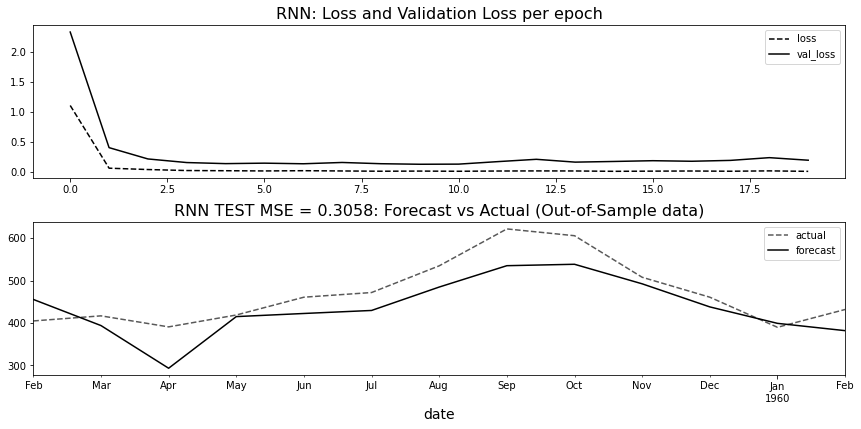

In [30]:
air_rnn, history_a_rnn = train_model_pt('RNN', **params_air)

### Avg Daily Temperature

0/500 - Loss:  1.2329455614089966, val_loss: 0.8055887222290039
20/500 - Loss:  0.4126690924167633, val_loss: 0.394985169172287
40/500 - Loss:  0.3868098556995392, val_loss: 0.37997812032699585
60/500 - Loss:  0.3489300012588501, val_loss: 0.3680422306060791
80/500 - Loss:  0.3241676986217499, val_loss: 0.3655868470668793
100/500 - Loss:  0.2946079969406128, val_loss: 0.38076359033584595
120/500 - Loss:  0.2672809660434723, val_loss: 0.44367095828056335
140/500 - Loss:  0.2485290765762329, val_loss: 0.4423491060733795
160/500 - Loss:  0.24036666750907898, val_loss: 0.43555206060409546
180/500 - Loss:  0.23144499957561493, val_loss: 0.5087984204292297
200/500 - Loss:  0.2161666601896286, val_loss: 0.4919579327106476
220/500 - Loss:  0.2068977952003479, val_loss: 0.48396703600883484
240/500 - Loss:  0.19619280099868774, val_loss: 0.5666154026985168
260/500 - Loss:  0.1868569552898407, val_loss: 0.5428931713104248
280/500 - Loss:  0.1854366958141327, val_loss: 0.5348309278488159
300/500 -

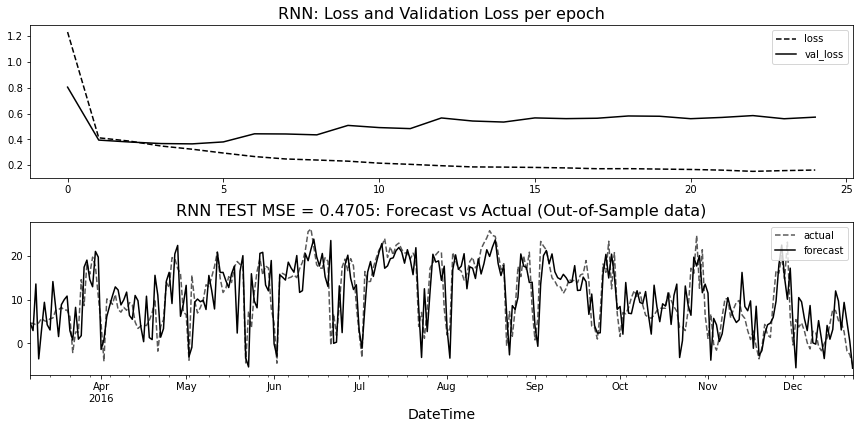

In [31]:
params_dw = {'input_size':x_train_air.shape[1],
'output_size':1,
'units':32,
'n_layers':1,
'epochs': 500,
'print_every': 20,
'lr': 0.01,
'train_data': (x_train_dw, y_train_dw),
'val_data': (x_val_dw, y_val_dw),
'test_data': (x_test_dw, y_test_dw),
'idx': test_dw.index,
'scale': scale_dw}

dw_rnn, history_dw_rnn = train_model_pt('RNN', **params_dw)

### Energy Consumption

0/500 - Loss:  1.2074775695800781, val_loss: 1.1554529666900635
20/500 - Loss:  0.09892001003026962, val_loss: 0.1639610230922699
40/500 - Loss:  0.09223025292158127, val_loss: 0.14392678439617157
60/500 - Loss:  0.08231490850448608, val_loss: 0.14059948921203613
80/500 - Loss:  0.06764303892850876, val_loss: 0.1341576874256134
100/500 - Loss:  0.06403852254152298, val_loss: 0.13636499643325806
120/500 - Loss:  0.06103507801890373, val_loss: 0.13296081125736237
140/500 - Loss:  0.04860025271773338, val_loss: 0.12779174745082855
160/500 - Loss:  0.04917295649647713, val_loss: 0.130415141582489
180/500 - Loss:  0.04696081206202507, val_loss: 0.12652704119682312
200/500 - Loss:  0.04961913824081421, val_loss: 0.12358243018388748
220/500 - Loss:  0.04590606689453125, val_loss: 0.12282468378543854
240/500 - Loss:  0.047694239765405655, val_loss: 0.12262727320194244
260/500 - Loss:  0.04879830405116081, val_loss: 0.13641399145126343
280/500 - Loss:  0.044985659420490265, val_loss: 0.12162096

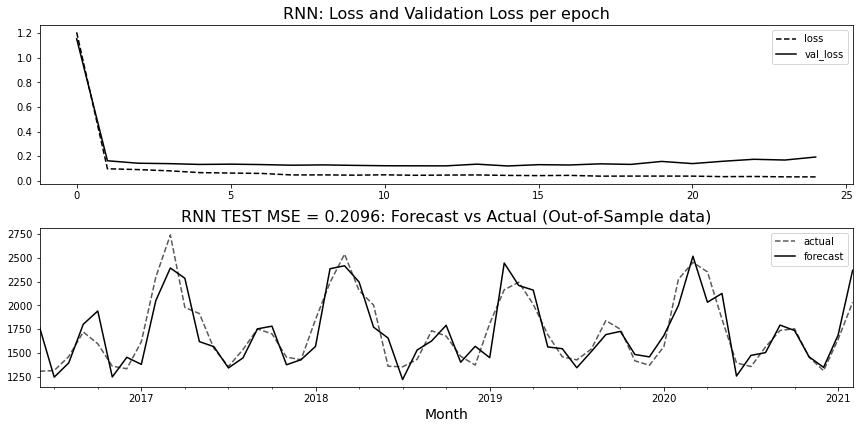

In [32]:
params_en = {'input_size':x_train_air.shape[1],
'output_size':1,
'units':32,
'n_layers':1,
'epochs': 500,
'print_every': 20,
'lr': 0.01,
'train_data': (x_train_en, y_train_en),
'val_data': (x_val_en, y_val_en),
'test_data': (x_test_en, y_test_en),
'idx': test_en.index,
'scale': scale_en}

en_rnn, history_en_rnn = train_model_pt('RNN', **params_en)

## LSTM Model 
* The math from PyTorch LSTM class documentation

$$
\large
\begin{array}{ll} \\
        i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
        f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
        g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
        o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
        c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
        h_t = o_t \odot \tanh(c_t) \\
    \end{array}
$$

In [33]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.lstm = nn.LSTM(input_size, n_features, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        lstm_o, hn = self.lstm(x, hn)
        lstm_o = self.dropout(lstm_o)
        # reshape
        lstm_o = lstm_o.view(-1, self.hidden_dim)
        output = self.fc(lstm_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, 1, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, 1, self.hidden_dim).zero_())
        return hidden

### Air Passenger

0/500 - Loss:  1.0155377388000488, val_loss: 2.96325945854187
25/500 - Loss:  0.13285502791404724, val_loss: 0.4593890905380249
50/500 - Loss:  0.05234101042151451, val_loss: 0.4414792060852051
75/500 - Loss:  0.032947517931461334, val_loss: 0.3788365423679352
100/500 - Loss:  0.02538747899234295, val_loss: 0.38961848616600037
125/500 - Loss:  0.026118023321032524, val_loss: 0.38657280802726746
150/500 - Loss:  0.02342633344233036, val_loss: 0.4561809003353119
175/500 - Loss:  0.02590988017618656, val_loss: 0.38252976536750793
200/500 - Loss:  0.025403739884495735, val_loss: 0.33537736535072327
225/500 - Loss:  0.02134942263364792, val_loss: 0.40164145827293396
250/500 - Loss:  0.02052276022732258, val_loss: 0.3259294927120209
275/500 - Loss:  0.01860632747411728, val_loss: 0.40071579813957214
300/500 - Loss:  0.02073643170297146, val_loss: 0.2016814947128296
325/500 - Loss:  0.020230619236826897, val_loss: 0.2768532633781433
350/500 - Loss:  0.01598665490746498, val_loss: 0.3958998918

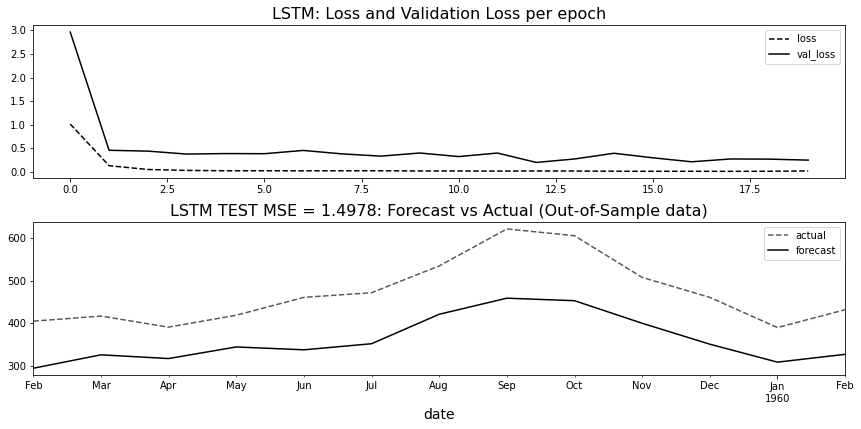

In [34]:
air_lstm, history_a_lstm = train_model_pt('LSTM', **params_air)

### Avg Daily Temperature

0/500 - Loss:  1.079797625541687, val_loss: 0.8478728532791138
20/500 - Loss:  0.44048845767974854, val_loss: 0.3906320035457611
40/500 - Loss:  0.34886419773101807, val_loss: 0.34673500061035156
60/500 - Loss:  0.3016970157623291, val_loss: 0.3044196665287018
80/500 - Loss:  0.2678545415401459, val_loss: 0.3189859688282013
100/500 - Loss:  0.24293644726276398, val_loss: 0.3350120782852173
120/500 - Loss:  0.22291205823421478, val_loss: 0.3172066807746887
140/500 - Loss:  0.2094251960515976, val_loss: 0.32106393575668335
160/500 - Loss:  0.18692144751548767, val_loss: 0.33413034677505493
180/500 - Loss:  0.16937217116355896, val_loss: 0.32546642422676086
200/500 - Loss:  0.167899951338768, val_loss: 0.3509746193885803
220/500 - Loss:  0.16560006141662598, val_loss: 0.31494659185409546
240/500 - Loss:  0.15542854368686676, val_loss: 0.3587184250354767
260/500 - Loss:  0.13912399113178253, val_loss: 0.37499722838401794
280/500 - Loss:  0.1472335159778595, val_loss: 0.3270971477031708
300

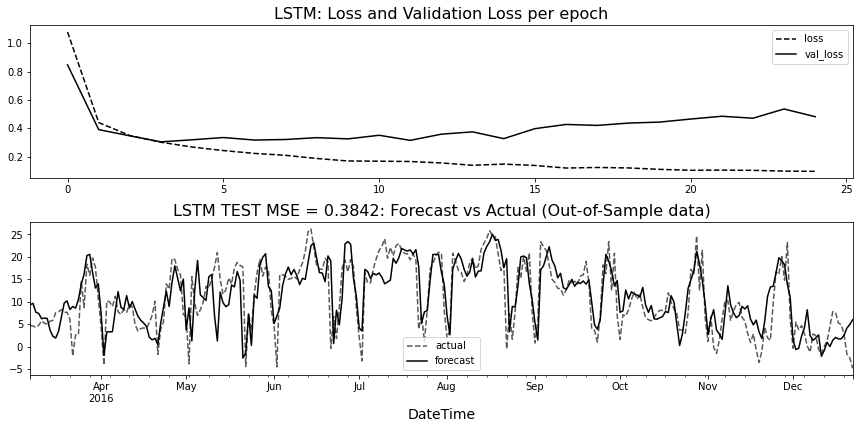

In [35]:
dw_lstm, history_dw_lstm = train_model_pt('LSTM', **params_dw)

### Energy Consumption

0/500 - Loss:  0.9566537141799927, val_loss: 1.2323977947235107
20/500 - Loss:  0.12610481679439545, val_loss: 0.22536611557006836
40/500 - Loss:  0.07922565191984177, val_loss: 0.17509418725967407
60/500 - Loss:  0.07154582440853119, val_loss: 0.1552431732416153
80/500 - Loss:  0.05970320105552673, val_loss: 0.14932619035243988
100/500 - Loss:  0.06180693581700325, val_loss: 0.13732773065567017
120/500 - Loss:  0.0513312928378582, val_loss: 0.1304495930671692
140/500 - Loss:  0.0483069010078907, val_loss: 0.12598031759262085
160/500 - Loss:  0.04385305196046829, val_loss: 0.13164697587490082
180/500 - Loss:  0.042750678956508636, val_loss: 0.12868312001228333
200/500 - Loss:  0.03871450573205948, val_loss: 0.12752918899059296
220/500 - Loss:  0.03296077251434326, val_loss: 0.13587290048599243
240/500 - Loss:  0.03489597886800766, val_loss: 0.12045343965291977
260/500 - Loss:  0.037670619785785675, val_loss: 0.1077548936009407
280/500 - Loss:  0.035433702170848846, val_loss: 0.10717635

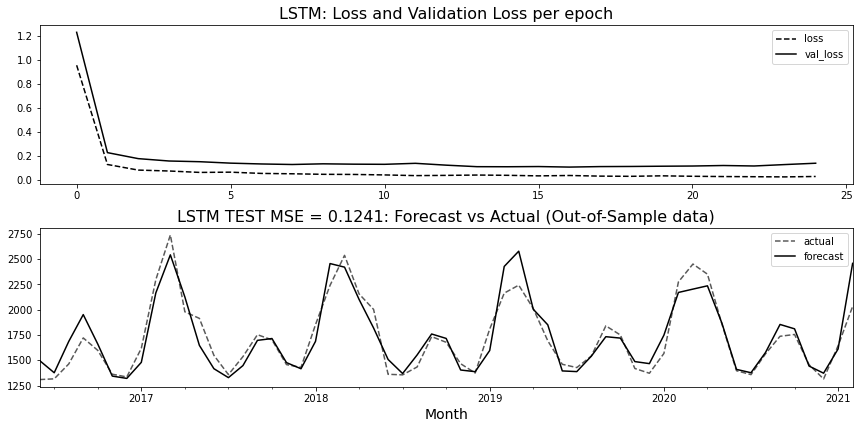

In [36]:
en_lstm, history_en_lstm = train_model_pt('LSTM', **params_en)

## LSTM with Dropout

In [37]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.lstm = nn.LSTM(input_size, n_features, n_layers, batch_first=True, dropout=0.70)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        lstm_o, hn = self.lstm(x, hn)
        lstm_o = self.dropout(lstm_o)
        # reshape
        lstm_o = lstm_o.view(-1, self.hidden_dim)
        output = self.fc(lstm_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, 1, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, 1, self.hidden_dim).zero_())
        return hidden

0/500 - Loss:  1.0334603786468506, val_loss: 1.268944263458252
20/500 - Loss:  0.12089824676513672, val_loss: 0.24203366041183472
40/500 - Loss:  0.0673750787973404, val_loss: 0.17892377078533173
60/500 - Loss:  0.06975316256284714, val_loss: 0.16580747067928314
80/500 - Loss:  0.05615755170583725, val_loss: 0.1556994616985321
100/500 - Loss:  0.056523509323596954, val_loss: 0.14673854410648346
120/500 - Loss:  0.05399199575185776, val_loss: 0.13788951933383942
140/500 - Loss:  0.04929530248045921, val_loss: 0.13737203180789948
160/500 - Loss:  0.047441065311431885, val_loss: 0.12971998751163483
180/500 - Loss:  0.049784403294324875, val_loss: 0.13420157134532928
200/500 - Loss:  0.04259834066033363, val_loss: 0.12869009375572205
220/500 - Loss:  0.0367003008723259, val_loss: 0.1274411976337433
240/500 - Loss:  0.036278121173381805, val_loss: 0.12923051416873932
260/500 - Loss:  0.040607109665870667, val_loss: 0.12530194222927094
280/500 - Loss:  0.03403118997812271, val_loss: 0.121123

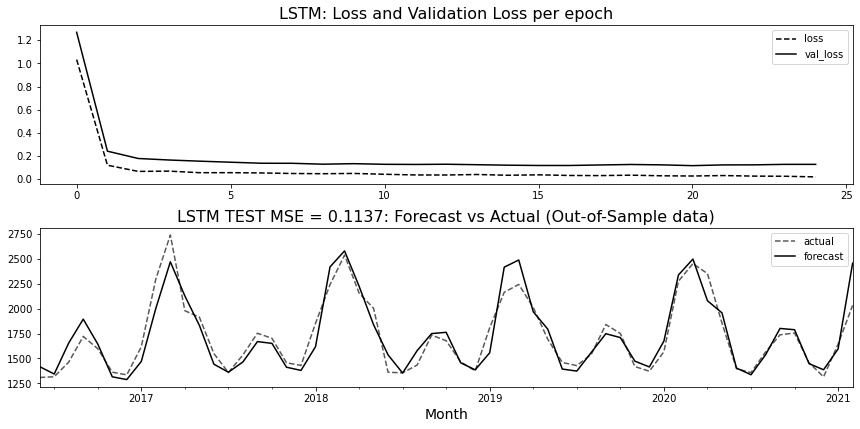

In [38]:
en_lstm_d, history_en_lstm_d = train_model_pt('LSTM', **params_en)

## GRU
* The math from the PyTorch GRU documentation

$$
\large
\begin{array}{ll}
        r_t = \sigma(W_{ir} x_t + b_{ir} + W_{hr} h_{(t-1)} + b_{hr}) \\
        z_t = \sigma(W_{iz} x_t + b_{iz} + W_{hz} h_{(t-1)} + b_{hz}) \\
        n_t = \tanh(W_{in} x_t + b_{in} + r_t * (W_{hn} h_{(t-1)}+ b_{hn})) \\
        h_t = (1 - z_t) * n_t + z_t * h_{(t-1)}
    \end{array}
$$

In [39]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(GRU, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.gru = nn.GRU(input_size, n_features, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        gru_o, hn = self.gÇru(x, hn)
        gru_o = self.dropout(gru_o)
        # reshape
        gru_o = gru_o.view(-1, self.hidden_dim)
        output = self.fc(gru_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, 1, self.hidden_dim).zero_()
        return hidden

### Air Passenger

0/500 - Loss:  1.025316834449768, val_loss: 2.921034097671509
25/500 - Loss:  0.10860145837068558, val_loss: 0.5246278643608093
50/500 - Loss:  0.04526595026254654, val_loss: 0.45505133271217346
75/500 - Loss:  0.026050902903079987, val_loss: 0.4298590123653412
100/500 - Loss:  0.03201187402009964, val_loss: 0.39654502272605896
125/500 - Loss:  0.029713459312915802, val_loss: 0.43778130412101746
150/500 - Loss:  0.03177417069673538, val_loss: 0.3517855405807495
175/500 - Loss:  0.022546997293829918, val_loss: 0.425816148519516
200/500 - Loss:  0.024310866370797157, val_loss: 0.5208850502967834
225/500 - Loss:  0.024277498945593834, val_loss: 0.5360041260719299
250/500 - Loss:  0.020360255613923073, val_loss: 0.4839755594730377
275/500 - Loss:  0.02298249490559101, val_loss: 0.45786961913108826
300/500 - Loss:  0.01953476294875145, val_loss: 0.40682923793792725
325/500 - Loss:  0.017266850918531418, val_loss: 0.37463080883026123
350/500 - Loss:  0.017832690849900246, val_loss: 0.3610664

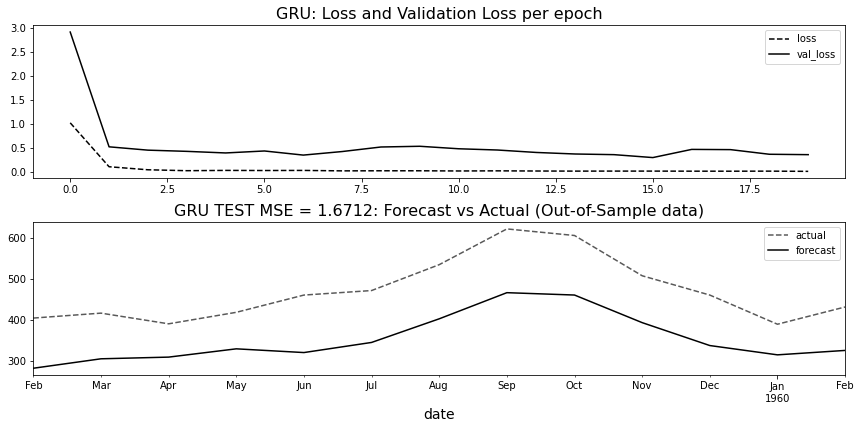

In [40]:
air_gru, history_a_gru = train_model_pt('GRU', **params_air)

### Avg Daily Temperature

0/500 - Loss:  1.0901281833648682, val_loss: 0.8750116229057312
20/500 - Loss:  0.42839351296424866, val_loss: 0.3740423619747162
40/500 - Loss:  0.3451480269432068, val_loss: 0.3237614929676056
60/500 - Loss:  0.30995985865592957, val_loss: 0.30045387148857117
80/500 - Loss:  0.28046977519989014, val_loss: 0.3192562460899353
100/500 - Loss:  0.25046125054359436, val_loss: 0.3354942202568054
120/500 - Loss:  0.2235153168439865, val_loss: 0.36684516072273254
140/500 - Loss:  0.20350898802280426, val_loss: 0.37139585614204407
160/500 - Loss:  0.19854296743869781, val_loss: 0.3568372130393982
180/500 - Loss:  0.17904187738895416, val_loss: 0.39437562227249146
200/500 - Loss:  0.16703292727470398, val_loss: 0.46579092741012573
220/500 - Loss:  0.15739665925502777, val_loss: 0.46962499618530273
240/500 - Loss:  0.153300479054451, val_loss: 0.4752901494503021
260/500 - Loss:  0.14471200108528137, val_loss: 0.4536195695400238
280/500 - Loss:  0.13831399381160736, val_loss: 0.5046283006668091


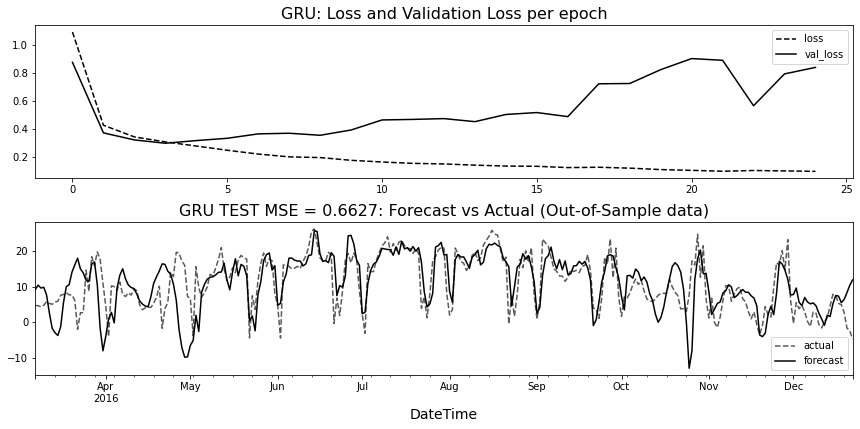

In [41]:
dw_gru, history_dw_gru = train_model_pt('GRU', **params_dw)

### Energy Consumption

0/500 - Loss:  1.0157889127731323, val_loss: 1.4039651155471802
20/500 - Loss:  0.13936631381511688, val_loss: 0.24455973505973816
40/500 - Loss:  0.08857899159193039, val_loss: 0.17964047193527222
60/500 - Loss:  0.06987758725881577, val_loss: 0.15534617006778717
80/500 - Loss:  0.06406918913125992, val_loss: 0.14826643466949463
100/500 - Loss:  0.0629633367061615, val_loss: 0.13995756208896637
120/500 - Loss:  0.06215731054544449, val_loss: 0.12811675667762756
140/500 - Loss:  0.05349433049559593, val_loss: 0.12708045542240143
160/500 - Loss:  0.047997258603572845, val_loss: 0.12411698698997498
180/500 - Loss:  0.04198940470814705, val_loss: 0.12009044736623764
200/500 - Loss:  0.042479097843170166, val_loss: 0.11544675379991531
220/500 - Loss:  0.039921022951602936, val_loss: 0.11168850213289261
240/500 - Loss:  0.03700527548789978, val_loss: 0.11088526993989944
260/500 - Loss:  0.0380057692527771, val_loss: 0.11577007174491882
280/500 - Loss:  0.03662758693099022, val_loss: 0.10834

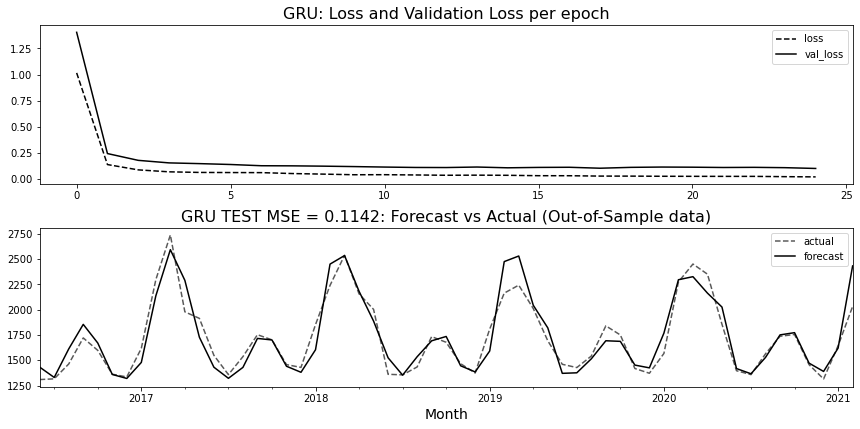

In [42]:
en_gru, history_en_gru = train_model_pt('GRU', **params_en)

## There is more

In [43]:
n_hidden = 32
input_size = x_train_en.shape[1]
n_layers = 1
output = 1

In [44]:
model_lstm_seq = torch.nn.Sequential(
    torch.nn.LSTM(input_size, n_hidden, n_layers),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(n_hidden, output)
)

In [45]:
model_gru_seq = torch.nn.Sequential(
    torch.nn.GRU(input_size, n_hidden, n_layers),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(n_hidden, output)
)

In [46]:
model_lstm_seq

Sequential(
  (0): LSTM(10, 32)
  (1): Dropout(p=0.5, inplace=False)
  (2): Linear(in_features=32, out_features=1, bias=True)
)